# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import markdown
from sklearn.preprocessing import Imputer
from sklearn import preprocessing as p
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

## Assessing 'azdias' dataset

In [3]:
# Checking the first few rows of the 'azdias' dataset.

azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# Finding the number of rows in the 'azdias' dataframe.

len(azdias.axes[0])

891221

In [5]:
# Finding the number of columns in the 'azdias' dataframe.

len(azdias.axes[1])

85

In [6]:
# Finding column names, null objects and how many rows and columns are in the 'azdias' dataset.

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
# Finding summary statistics for the 'azdias' dataset.

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


## Assessing the feat_info dataset (azdias summary)

In [8]:
# Grabbing the first few rows of the azdias summary dataset.

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
# Finding the number of rows in the azdias summary dataset.

len(feat_info.axes[0])

85

In [10]:
# Finding the number of columns in the azdias summary dataset.

len(feat_info.axes[1])

4

In [11]:
# Finding column names, null objects and how many rows and columns are in the azdias summary dataset.

feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [12]:
# Finding summary statistics for the azdias summary dataset.

feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ANZ_HH_TITEL,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify missing or unknown data values. These values will need to be converted into NaN.

azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [14]:
# Getting rid of the brackets and converting the string to a list.

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',')

feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


**NOTE: This next step was extremley difficult for me. I tried everything to try and pass the list of 'missing_or_unknown' values into a for loop and I just wouldn't work. I tried replace(), map(), lamba(), as well as where() etc. I was able to find in the mentor questions and answers that I was actually on the right track to begin with. The following for loop was from the questions and answers section, this is not my own code. I took out the replace() and split() because I already had that.** 

In [15]:
# Grabbing the 

for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nan_values = azdias.isnull().sum()

nan_values

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [17]:
# Grabbing the total number of missing values 

nan_values.sum()

8373929

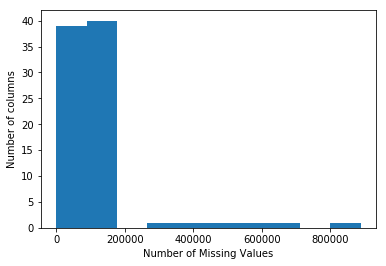

In [18]:
# Investigate patterns in the amount of missing data in each column.
# Checking what distribution looks like. 


plt.hist(nan_values)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of columns')
plt.show()

I'm going to remove any column where the number of missing values is greater than 200,000. The histogram above shows us that there are a handful of columns. Let's find them.

In [19]:
# Finding the columns where missing values are greater than 200,000.

nan_values = nan_values[nan_values>200000] 

nan_values

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [20]:
# Dropping the 6 outlier columns on the original 'azdias' dataset with more than 200,000 missing values.
# One the original azdias dataset there were 85 columns, there are now 79, dropped columns was a success.

azdias = azdias[azdias.columns[azdias.isnull().sum() < 200000]]

azdias.isnull().sum().count()

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

The only pattern that was found was there were 6 columns with outliers of more than 200,000 missing values. All other columns had less than 200,000 missing values. The columns that were dropped were:

- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?

# using isnull() and sum() by row axis so that we can figure out how many NaN values are in each row.

# creating a new variable to pass into the distrubution visulization below.

azdias_hist = azdias.isnull().sum(axis=1)

azdias_hist

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

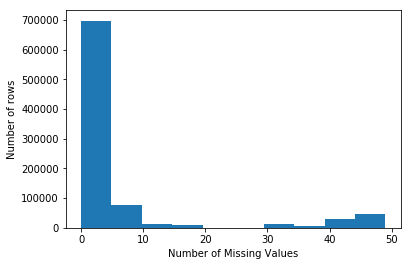

In [22]:
# Before I break the data into two subsets, I want to find where the best place to break them would be. For this, I'll be
# using distribution.

plt.hist(azdias_hist)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of rows')
plt.show()

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Because 5 seems to be where the majority of our rows with less than 5 missing values are
# I'm going to pass in 5 as the threshold.

azdias_normal = azdias[azdias.isnull().sum(axis=1) < 5]

azdias_normal.isnull().sum(axis=1).sum()

174905

In [24]:
azdias_outlier = azdias[azdias.isnull().sum(axis=1) > 5]

# The outliers have more than 5 missing values, and I will pass that in for out outlier variable

azdias_outlier.isnull().sum(axis=1).sum()

4747824

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Finding the columns with the least missing data.

smallest_missing_values = azdias.isnull().sum()

smallest_missing_values.nsmallest()


ANREDE_KZ            0
FINANZ_MINIMALIST    0
FINANZ_SPARER        0
FINANZ_VORSORGER     0
FINANZ_ANLEGER       0
dtype: int64

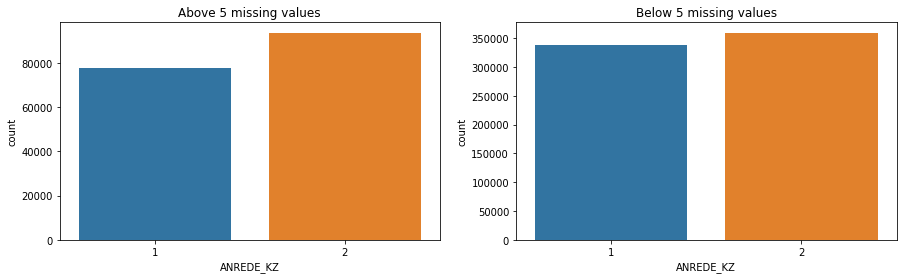

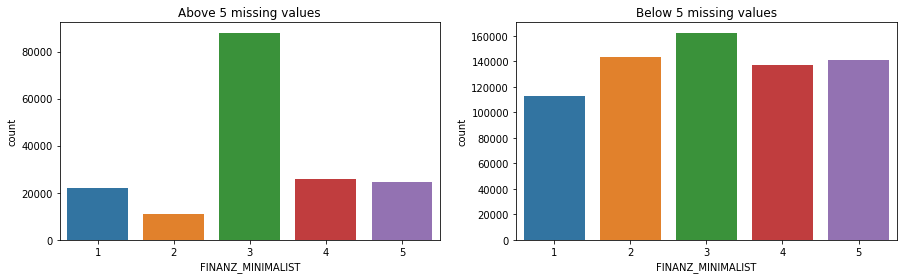

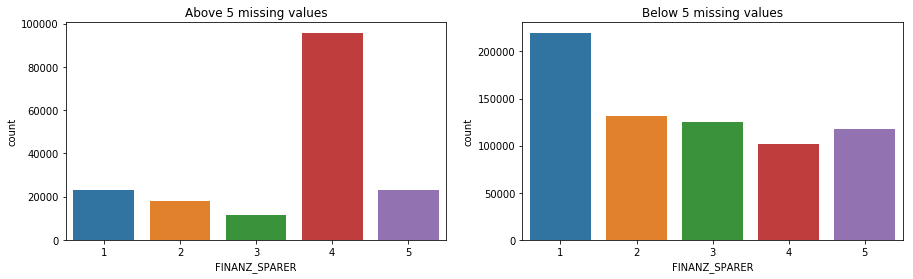

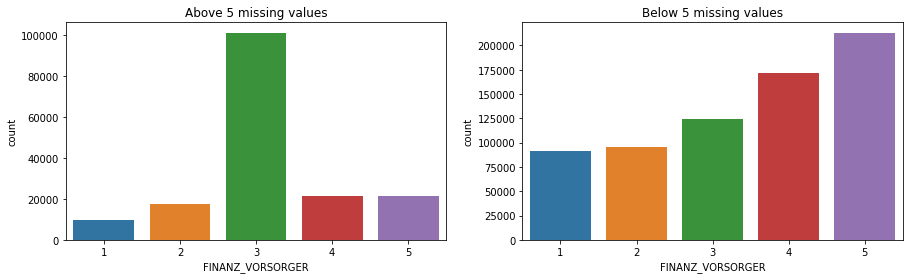

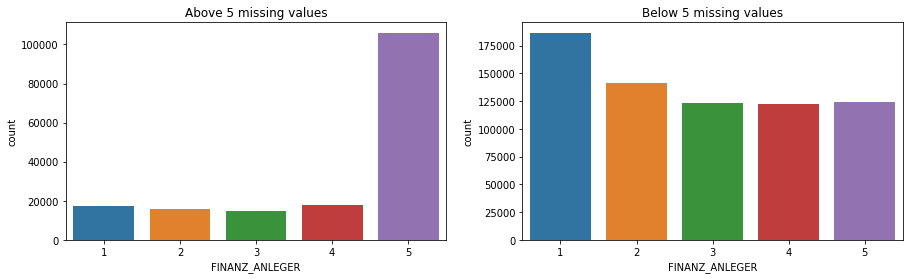

In [26]:
# taking the above smallest columns with the least missing data and creating a list.

small_list = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']


# I was able to find an example of this graph on mentor questions and answers, I was lost on how to do it. 

def above_below_graph(column_name):
    fig = plt.figure(figsize=(15,4))
    axis1 = fig.add_subplot(121)
    axis1.title.set_text('Above 5 missing values')
    sns.countplot(azdias.loc[azdias_outlier.index, column_name])
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Below 5 missing values')
    sns.countplot(azdias.loc[azdias_normal.index, column_name])
    
for column_name in small_list:
    above_below_graph(column_name)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Qualitativley, there is a noticebly large difference between data with more than 5 missing values and data with less than 5 missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?

# The third column in feat_info is 'type', this gives us a list of the type of encoding for every column. value_counts adds
# each catergory.

feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [28]:
# Originally I had used the above code to find the features of each data type. I wanted to make sure I was on the right track,
# and was able to find in mentor questions and answers the below code. I was close, but this is better and more specific.

att_list = azdias_normal.columns.tolist() 
feat_info_exist = feat_info[feat_info['attribute'].isin(att_list)] 
feat_info_exist['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# From the list above I am choosing to find the binary variable that has non-numeric values. Let's find that column.

# initializing a list of the column names to store.
binary_columns = []

# looping through the azdias_normal dataframe to find columns where there are values of 2. (1, 0, etc)
for column in azdias_normal.columns:
    if azdias_normal[column].nunique() == 2:
        binary_columns.append(column)
        
binary_columns

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [30]:
# Now that we know the exact columns are binary, let's find out which one has non-numeric values.

azdias_normal[['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W
6,2,0,0.0,1.0,W
7,1,0,0.0,1.0,W
8,1,1,0.0,2.0,W
9,2,1,0.0,2.0,W
10,2,0,0.0,2.0,W
18,2,0,0.0,1.0,W


In [31]:
# we can see above that 'OST_WEST_KZ' is the column that has non-numeric variables. Let's find what the values are
# so we can create a dummie column.

azdias_normal['OST_WEST_KZ'].value_counts()

W    546039
O    151070
Name: OST_WEST_KZ, dtype: int64

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Creating the dummie columns, using drop_first so that it drops the original column.

azdias_normal = pd.get_dummies(azdias_normal, columns=['OST_WEST_KZ'], drop_first=True)

In [33]:
# checking the column that was encoded. Success!

azdias_normal['OST_WEST_KZ_W'].value_counts()

1    546039
0    151070
Name: OST_WEST_KZ_W, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

From the given list, I chose to find the binary column that contained a non-numeric value. Once I was able to find it, I isolated it and used pd.get_dummies() to re encode it to 0 and 1. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables

From Data_Dictionary.md:


 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)





In [34]:
# Creating two new columns from the original PRAEGENDE_JUGENDJAHRE column.

azdias_normal['decade'] = azdias_normal['PRAEGENDE_JUGENDJAHRE']

azdias_normal['movement'] = azdias_normal['PRAEGENDE_JUGENDJAHRE']

**Note: I was able to find how to do this in Udacity mentor questions and answers. I had tried a for loop and failed. I knew I had to create two new columns but couldn't figure out how to map them. This is not my orginal code but I understand what it is doing. An explanation for what is happening in the code box below will be in 1.1.2 discussion.**

In [35]:
# Mapping the values for the new column, 'decade' and 'movement' in a dictionary.

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# Passing in the dictionaries above to create two new columns with the new values.

azdias_normal['decade'].replace(decade, inplace=True)
azdias_normal['movement'].replace(movement, inplace=True)

### Investigate "CAMEO_INTL_2015" and engineer two new variables.

From Data_Dictionary.md

4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

**NOTE:** I ran into a massive issue mapping the original values of CAMEO_INTL_2015. When trying to weight the PCA components via a function in section 2.3 (further below), it kept reading the error, "Shape of passed values is (1, 74), indices imply (1, 76)". This mean that there were two columns that were still NaN, even though I had converted them. It didn't occur to me to check that the numbers listed in Data_Dictionary.md and see if they were actually being used instead of just passing them into a dictionary. Using unique() on CAMEO_INTL_2015 tells us that there's a handful of values being used. Originally I had mapped every value. I also tried using ' ' around the first numbers and that didn't work either.

In [36]:
test = azdias_normal['CAMEO_INTL_2015'].sort_values().unique()

test

array(['12', '13', '14', '15', '22', '23', '24', '25', '31', '32', '33',
       '34', '35', '41', '43', '44', '45', '51', '52', '54', '55', nan], dtype=object)

In [37]:
# Creating two new columns from the orginal 'CAMEO_INTL_2015' column.

azdias_normal['wealth'] = azdias_normal['CAMEO_INTL_2015']

azdias_normal['life stage'] = azdias_normal['CAMEO_INTL_2015']


In [38]:
# Mapping the values for the new columns 'wealth' and 'life stage' into a dictionary.

wealth = {12:1, 13:1, 14:1, 15:1, 22:2, 23:2, 24:2, 25:2, 31:3, 
          32:3, 33:3, 34:3, 35:3, 41:4, 43:4, 44:4, 45:4, 51:5, 52:5, 
          54:5, 55:5}

life_stage = {12:2, 13:3, 14:4, 15:5, 22:2, 23:3, 24:4, 25:5, 31:1, 
              32:2, 33:3, 34:4, 35:5, 41:1, 43:3, 44:4, 45:5, 51:1, 52:2, 
              54:4, 55:5}

# Passing in the dictionaries above to create two new columns with the new values.

azdias_normal['wealth'] = azdias_normal.replace(wealth, inplace=True)
azdias_normal['life stage'] = azdias_normal.replace(life_stage, inplace=True)

In [39]:
# Checking to make sure out new columns were added. They are listed at the bottom. There were originally 79 columns and there
# are not 83, success!

azdias_normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697109 entries, 1 to 891220
Data columns (total 83 columns):
ALTERSKATEGORIE_GROB     695692 non-null float64
ANREDE_KZ                697109 non-null int64
CJT_GESAMTTYP            697109 non-null float64
FINANZ_MINIMALIST        697109 non-null int64
FINANZ_SPARER            697109 non-null int64
FINANZ_VORSORGER         697109 non-null int64
FINANZ_ANLEGER           697109 non-null int64
FINANZ_UNAUFFAELLIGER    697109 non-null int64
FINANZ_HAUSBAUER         697109 non-null int64
FINANZTYP                697109 non-null int64
GFK_URLAUBERTYP          697109 non-null float64
GREEN_AVANTGARDE         697109 non-null int64
HEALTH_TYP               684858 non-null float64
LP_LEBENSPHASE_FEIN      697107 non-null float64
LP_LEBENSPHASE_GROB      697108 non-null float64
LP_FAMILIE_FEIN          697109 non-null float64
LP_FAMILIE_GROB          697109 non-null float64
LP_STATUS_FEIN           697109 non-null float64
LP_STATUS_GROB           

#### Discussion 1.2.2: Engineer Mixed-Type Features

I want to explain a little more about what exactly is going on in the code above, even though it's not my own (found in Udacity mentor questions and answers), this project has been very difficult. However, I want to have a good understanding if I didn't create it. I essentially had to figure out a way to map the values stored inside the original columns 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. This was a little more tricky because I had to not only create a new columns for those values, but two (for different values). A breakdown of the code is below.

**decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}**

An explanation of the above code:

There were 15 values that were being broken apart by the decade in which it took place (1-15). Those 1-15 needed to be mapped with a numerical value. The way we can do that is with a dictionary. After the colon, there are number 1-6, those correspond to a particular decade. We also have to refer to Data_Dictionary.md to understand those values. As we can see below 1:1. This would mean that for value 1, specify that it is from 1 (40s). For value 2, specify that is also from 1 (40s). For value 3, specify that it is from 2 (50s). And so on and so forth.


**azdias_normal['decade'].replace(decade, inplace=True)** 

An explanation of the above code:

I am taking the azdias_normal dataframe, and telling python that I want to replace the column that I created, 'decade', with the dictionary of mapped values, 'decade' from the first code line. I am using inplace=True because I don't want to create another variable, I just want to change the original dataframe.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# I need to deal with the rest of the mixed columns. I'm going to create a list of the column names and drop them along with 
# PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [41]:
# When trying to execute the imputer below in section 2.1, I found that there was one more column that had mixed type variables.
# I'm going to drop this column as well in the dropping column section below this cell. 

azdias_normal['CAMEO_DEU_2015'].value_counts()

6B    50462
8A    47062
4C    41522
2D    31058
3C    30702
3D    30611
7A    30540
8B    29634
4A    28333
8C    28294
9D    25439
9B    24831
9C    21983
7B    21736
9A    18309
2C    16902
8D    16096
6E    14805
2B    13418
5D    13163
6C    13126
2A    11278
1D    10921
1A     9603
5B     9124
5A     9102
5C     8446
7C     7979
4B     7759
4D     7648
6A     5940
3A     5564
3B     5459
6D     5389
9E     4880
6F     4754
4E     4732
7D     4615
1E     4539
7E     4131
1C     3802
5F     3800
1B     3614
5E     3163
Name: CAMEO_DEU_2015, dtype: int64

In [42]:
# There is one more column that is labeled as an object. I'm going to convert this to int64.

azdias_normal['CAMEO_DEUG_2015'].value_counts()

8    121086
9     95442
6     94476
4     89994
2     72656
3     72336
7     69001
5     46798
1     32479
Name: CAMEO_DEUG_2015, dtype: int64

In [43]:
# Creating the list of column names to be passed into the drop function below. When I originally did this, 'KBA05_BAUMAX' was
# not listed in the index for azdias_normal. This column was probably filtered out when I did the filtering by NaN portion 
# of this project.

drop_list = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 
                'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'CAMEO_DEU_2015']

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains the columns that should be 
# passed to the algorithm functions.

# Dropping the original columns, 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. I do not need to drop the dummie column from 
# the first part of the project because I used drop_first=True. 

azdias_normal.drop(drop_list, axis=1, inplace=True)

In [45]:
# The columns were dropped. Success!

print(len(azdias_normal.columns))

76


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',')
    
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
                azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

    # remove selected columns and rows, ...
    
    azdias = azdias[azdias.columns[azdias.isnull().sum() < 200000]]
    azdias_normal = azdias[azdias.isnull().sum(axis=1) < 5]

    # select, re-encode, and engineer column values.
    
    azdias_normal = pd.get_dummies(azdias_normal, columns=['OST_WEST_KZ'], drop_first=True)
    
    azdias_normal['decade'] = azdias_normal['PRAEGENDE_JUGENDJAHRE']

    azdias_normal['movement'] = azdias_normal['PRAEGENDE_JUGENDJAHRE']
    
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    azdias_normal['decade'].replace(decade, inplace=True)
    
    azdias_normal['movement'].replace(movement, inplace=True)

    azdias_normal['wealth'] = azdias_normal['CAMEO_INTL_2015']

    azdias_normal['life stage'] = azdias_normal['CAMEO_INTL_2015']
    
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3,
             41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}

    life_stage = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5,
             41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}

    azdias_normal['wealth'] = azdias_normal.replace(wealth, inplace=True)
    
    azdias_normal['life stage'] = azdias_normal.replace(life_stage, inplace=True)

    drop_list = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 
                'CAMEO_INTL_2015', 'PLZ8_BAUMAX', 'CAMEO_DEU_2015']
    
    azdias_normal.drop(drop_list, axis=1, inplace=True)
    

    # Return the cleaned dataframe.
    
    return azdias_normal

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Finding all of the NaN values left in azdias_normal.

azdias_normal.isnull().sum().sum()

1570338

In [48]:
# Creating the imputer, telling it how we want to deal with missing values (replace with median and scan through rows)

azdias_imputer = Imputer(missing_values=np.NaN, strategy='median', axis=0)

# fitting the imputer model

azdias_imputer.fit(azdias_normal)

Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)

In [49]:
# Transforming and filling the NaN values

azdias_imputed = azdias_imputer.transform(azdias_normal)

In [50]:
# Apply feature scaling to the general population demographics data.

azdias_scaler = p.StandardScaler().fit_transform(azdias_imputed)

### Discussion 2.1: Apply Feature Scaling

I checked to find the sum of all null values in the original azdias_normal dataset. I then created an imputer to specify that I want to replace all of the NaN values with the median and scan through the rows to do it. I then fit the imputer by passing the azdias_normal dataset into it. I used another variable (azdias_imputed) to transform azdias_normal and fill the NaN values. I applied scaling via StandardScaler with fit_transform and passed azdias_imputed into it. Standard Scaler removes the mean and scales each feature/variable to unit variance, which essentially just means that it makes all of the numbers that same size, and comparing them is easier.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.

pca = PCA()

azdias_pca = pca.fit(azdias_scaler)


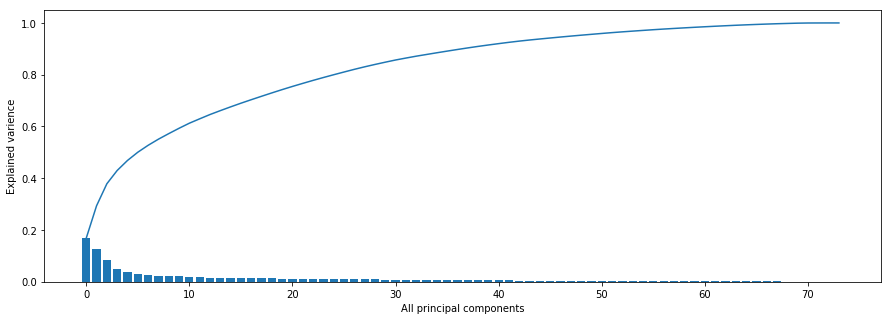

In [52]:
# Investigate the variance accounted for by each principal component.

# This was taken from Udacity classroom. I made many changes.

components = np.arange(len(pca.explained_variance_ratio_))
varience = pca.explained_variance_ratio_
cumilitave_values = np.cumsum(varience)

plt.figure(figsize=(15, 5))
plt.bar(components, varience)
plt.plot(cumilitave_values)
plt.xlabel('All principal components')
plt.ylabel('Explained varience')
plt.show()


In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.

select_pca = PCA(n_components=20)

azdias_pca2 = select_pca.fit_transform(azdias_scaler)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

This is where I started to get a little lost. From my understanding, PCA is just 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
components = pca.components_

components

array([[ -1.12034051e-01,   1.19024743e-02,   4.27020909e-02, ...,
         -5.10011689e-02,   9.58145332e-02,   1.18754011e-01],
       [  2.52774390e-01,   8.25170024e-02,  -1.20624057e-01, ...,
         -2.83021912e-02,  -2.45382859e-01,   1.96252162e-02],
       [  6.76872116e-02,  -3.62785921e-01,  -3.08248702e-02, ...,
         -2.04472626e-02,  -9.75525263e-02,  -4.07825113e-02],
       ..., 
       [ -9.03339728e-04,   6.90563721e-03,   2.36563814e-03, ...,
          1.13459615e-03,   6.63672443e-03,  -1.71346033e-03],
       [ -1.55023157e-03,  -8.85737703e-03,  -2.61050087e-03, ...,
         -8.36110348e-03,   1.95431459e-04,   2.70654995e-02],
       [  5.97033095e-16,  -3.45131920e-15,  -7.26115462e-16, ...,
          1.73472348e-17,  -1.64798730e-16,  -7.07106781e-01]])

In [55]:
def print_component(pca, comp):
    if comp <= len(pca.components_):
        weight_df = pd.DataFrame({'weight': pca.components_[comp]}, index=azdias_normal.columns)
        print("Most wieghted features for the component ", comp)
        print(weight_df.sort_values(by=['weight']).head(5))
        print(weight_df.sort_values(by=['weight']).tail(5))
    else:
        print('That is not the right input, please read the docstring before continuing.')
        
#Plot the first component
print_component(pca, 0)
#pca is the pca model object

ValueError: Shape of passed values is (1, 74), indices imply (1, 76)

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.